# Introduction

### This notebook focuses on detecting anomalies in financial markets using the XGBoost model and implementing an investment strategy based on the detected anomalies. The strategy uses key market indicators, such as price and moving averages, to generate buy, sell, or hold recommendations. Additionally, a chatbot is integrated to provide real-time insights and respond to user queries about the current strategy, anomalies, and market conditions.

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from flask import Flask, request, jsonify
import threading
from threading import Thread
import requests
import yfinance as yf

# Data Cleaning

In [71]:
dataset = pd.read_excel('../data/FinancialMarketData.xlsx', sheet_name='EWS')

# Select only the crucial columns
selected_columns = ['Y' ,'DXY', 'VIX', 'BDIY', 'CRY', 'Data']
dataset = dataset[selected_columns]

# Calculate moving averages
dataset['VIX_moving_average'] = dataset['VIX'].rolling(window=7).mean()
dataset['BDIY_moving_average'] = dataset['BDIY'].rolling(window=7).mean()
dataset['CRY_moving_average'] = dataset['CRY'].rolling(window=7).mean()
dataset['DXY_moving_average'] = dataset['DXY'].rolling(window=7).mean()

# Calculate ratio
dataset['DXY_to_VIX'] = dataset['DXY'] / dataset['VIX']

# Convert 'Data' column to datetime and set it as the index
dataset['Data'] = pd.to_datetime(dataset['Data'])  # Ensure the 'Data' column is in datetime format
dataset.set_index('Data', inplace=True)  # Set 'Data' as the index

# Handle missing values (if any)
dataset_cleaned = dataset.ffill().bfill()


print( dataset_cleaned.columns)

dataset_cleaned.describe()


Index(['Y', 'DXY', 'VIX', 'BDIY', 'CRY', 'VIX_moving_average',
       'BDIY_moving_average', 'CRY_moving_average', 'DXY_moving_average',
       'DXY_to_VIX'],
      dtype='object')


,Y,DXY,VIX,BDIY,CRY,VIX_moving_average,BDIY_moving_average,CRY_moving_average,DXY_moving_average,DXY_to_VIX
count,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000
mean,0.213321,90.934982,19.992169,2259.860486,245.247649,20.005920,2257.610904,245.190931,90.967069,5.192057
std,0.409837,11.379095,8.642157,2017.811888,68.278081,8.115228,1996.043251,67.991467,11.349187,1.780666
min,0.000000,71.329000,9.430000,291.000000,106.292900,10.151429,322.857143,119.503429,72.127000,1.291721
25%,0.000000,81.240500,13.640000,990.000000,184.705650,14.124286,1001.142857,184.704664,81.531929,3.808384
50%,0.000000,89.716000,17.980000,1518.000000,234.560000,17.757143,1512.285714,232.279100,89.828429,5.082427
75%,0.000000,97.404000,23.625000,2685.500000,301.539250,23.593571,2698.214286,302.611400,97.351929,6.438958
max,1.000000,119.820000,75.910000,11793.000000,467.570000,60.937143,10799.428571,446.368571,118.951429,10.005823


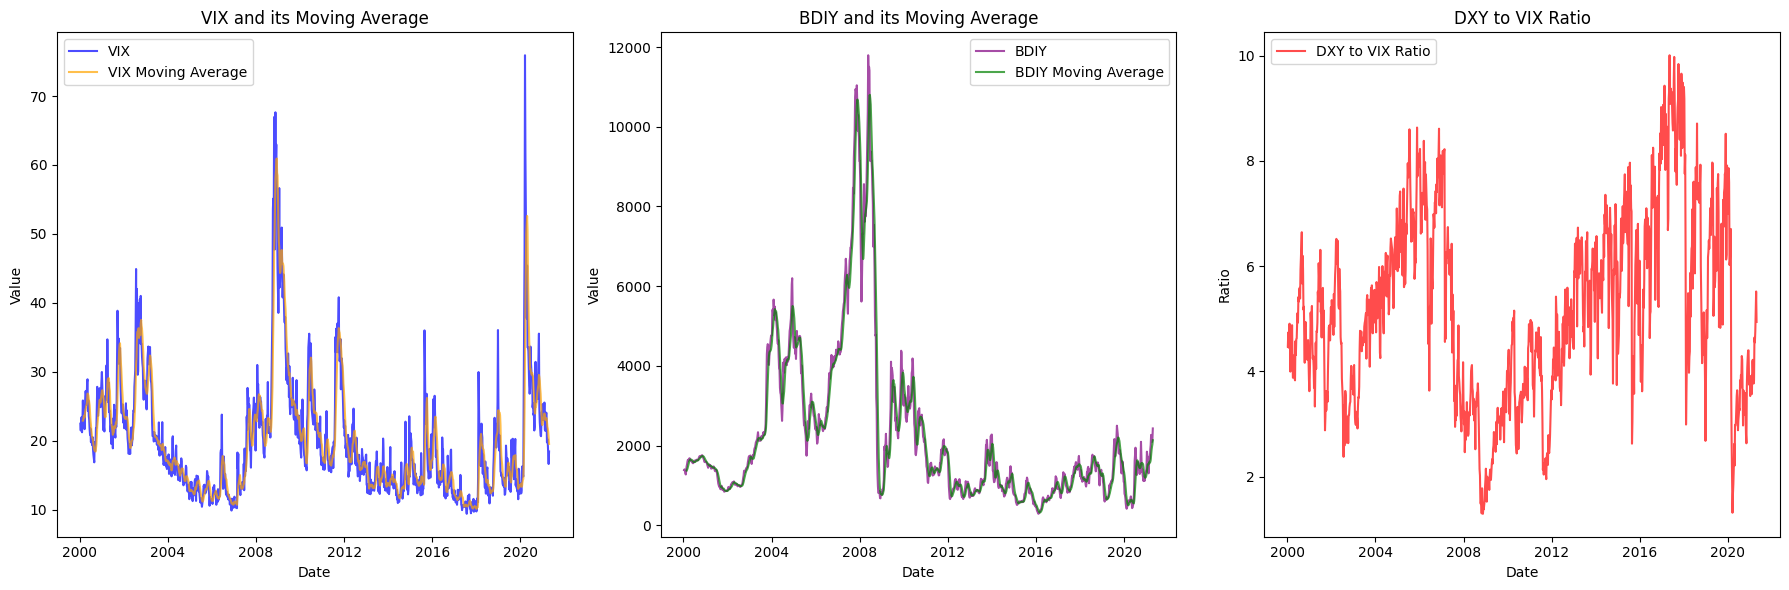

In [72]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot VIX and its Moving Average
axes[0].plot(dataset['VIX'], label='VIX', alpha=0.7, color='blue')
axes[0].plot(dataset['VIX_moving_average'], label='VIX Moving Average', alpha=0.7, color='orange')
axes[0].set_title("VIX and its Moving Average")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Value")
axes[0].legend()

# Plot BDIY and its Moving Average
axes[1].plot(dataset['BDIY'], label='BDIY', alpha=0.7, color='purple')
axes[1].plot(dataset['BDIY_moving_average'], label='BDIY Moving Average', alpha=0.7, color='green')
axes[1].set_title("BDIY and its Moving Average")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Value")
axes[1].legend()

# Plot DXY to VIX Ratio
axes[2].plot(dataset['DXY_to_VIX'], label='DXY to VIX Ratio', alpha=0.7, color='red')
axes[2].set_title("DXY to VIX Ratio")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Ratio")
axes[2].legend()


plt.tight_layout()

plt.show()


# Data Preperation For Training

In [73]:
X= dataset_cleaned.drop(columns=['Y'])
y=dataset_cleaned['Y']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Model Training

## Training the XGBoost Classifier

In [74]:
# Model inisialization
model = XGBClassifier(
    n_estimators=130, 
    learning_rate=0.3, 
    random_state=43, 
    scale_pos_weight=5
)

model.fit(X_train, y_train)

#  prediction model
y_pred = model.predict(X_test)

print("Classification Report :")
print(classification_report(y_test, y_pred))


Classification Report :
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       177
           1       0.75      0.72      0.73        46

    accuracy                           0.89       223
   macro avg       0.84      0.83      0.83       223
weighted avg       0.89      0.89      0.89       223



# Investment Strategy Implementation

### In this section, we will define and implement a data-driven investment strategy based on the model's predictions.


In [96]:
def fetch_real_time_data(tickers, window=5):
    """
    Fetch real-time data for the given tickers and calculate derived features.
    Returns a DataFrame containing the necessary features for the model.
    """
    # Initialiser un dictionnaire pour stocker les colonnes finales
    final_data = pd.DataFrame()

    # Télécharger les données pour chaque ticker individuellement
    for ticker in tickers:
        try:
            # Télécharger les données
            data = yf.download(ticker, period="5d", interval="1d")
            if data.empty:
                print(f"Aucune donnée disponible pour le ticker : {ticker}")
                continue
            # Ajouter les données de clôture au DataFrame final
            final_data[ticker] = data['Close']
        except Exception as e:
            print(f"Erreur pour le ticker {ticker} : {e}")

    # Si aucune donnée valide n'est disponible, créer un DataFrame vide avec un index
    if final_data.empty:
        print("Aucune donnée valide téléchargée. Simulation nécessaire.")
        index = pd.date_range(start="2025-01-10", periods=5)
        final_data = pd.DataFrame(index=index)

    # Simuler les données pour les tickers manquants
    index = final_data.index
    if 'BDIY' not in final_data.columns:
        final_data['BDIY'] = np.random.normal(1200, 50, size=len(index))
        print("Données simulées pour BDIY.")
    if 'CRY' not in final_data.columns:
        final_data['CRY'] = np.random.normal(300, 5, size=len(index))
        print("Données simulées pour CRY.")

    # Vérifier que les tickers obligatoires sont présents
    required_columns = ['DX-Y.NYB', '^VIX', 'BDIY', 'CRY']
    for col in required_columns:
        if col not in final_data.columns:
            print(f"Attention : le ticker {col} est manquant et ne sera pas simulé.")

    # Calculer les moyennes mobiles et les ratios
    if '^VIX' in final_data.columns and 'DX-Y.NYB' in final_data.columns:
        final_data['VIX_moving_average'] = final_data['^VIX'].rolling(window=window).mean()
        final_data['BDIY_moving_average'] = final_data['BDIY'].rolling(window=window).mean()
        final_data['CRY_moving_average'] = final_data['CRY'].rolling(window=window).mean()
        final_data['DXY_moving_average'] = final_data['DX-Y.NYB'].rolling(window=window).mean()
        final_data['DXY_to_VIX'] = final_data['DX-Y.NYB'] / final_data['^VIX']
    else:
        print("Impossible de calculer les moyennes mobiles ou les ratios : colonnes manquantes.")

    # Supprimer les lignes avec des NaN (causés par les moyennes mobiles)
    final_data = final_data.dropna()

    return final_data


In [100]:
def predict_anomaly(model, features):
    """
    Predict the probability of an anomaly using the model.
    Returns the anomaly probability.

    Parameters:
        - model: The pre-trained model.
        - features: A DataFrame containing the required columns for the model.

    Returns:
        - anomaly_prob: The probability of an anomaly (between 0 and 1).
    """
    # Ensure all required columns are present
    required_columns = [
        'DXY', 'VIX', 'BDIY', 'CRY', 'VIX_moving_average',
        'BDIY_moving_average', 'CRY_moving_average', 'DXY_moving_average', 'DXY_to_VIX'
    ]

    # Rename columns to match the training data
    column_mapping = {
        'DX-Y.NYB': 'DXY',
        '^VIX': 'VIX'
    }
    features = features.rename(columns=column_mapping)

    # Check if all required columns are present
    missing_columns = [col for col in required_columns if col not in features.columns]
    if missing_columns:
        raise ValueError(f"The following columns are missing: {missing_columns}")

    # Select the latest row for prediction
    latest_features = features.iloc[-1:].copy()  # Get the last row
    latest_features = latest_features[required_columns]  # Ensure the correct column order

    # Predict the probability of an anomaly
    anomaly_prob = model.predict_proba(latest_features)[0, 1]  # Anomaly probability
    return anomaly_prob


In [101]:
# Extract the features from the real-time data
features = real_time_data[[
    'DX-Y.NYB', '^VIX', 'BDIY', 'CRY', 'VIX_moving_average',
    'BDIY_moving_average', 'CRY_moving_average', 'DXY_moving_average', 'DXY_to_VIX'
]]

# Predict anomaly probability
try:
    anomaly_prob = predict_anomaly(model, features)
    print(f"Anomaly probability: {anomaly_prob:.2f}")
except ValueError as e:
    print(f"Error: {e}")


Anomaly probability: 0.95


In [ ]:
def define_real_time_strategy(latest_data):
    """
    Define the buy/sell/hold strategy based on real-time data and anomaly detection.
    """
    if latest_data:
        price = float(latest_data['price'])  # Convert to scalar
        moving_average = float(latest_data['moving_average'])  # Convert to scalar
        anomaly_prob = float(latest_data['anomaly_prob'])  # Convert to scalar

        # Decision logic
        if anomaly_prob > 0.8 and price < moving_average:
            return "Buy"
        elif price > moving_average * 1.1:
            return "Sell"
        else:
            return "Hold"
    else:
        return "No Data"


## Backtesting

In [ ]:
dataset_cleaned['price'] = dataset_cleaned['VIX']  # Use VIX as the default price

if 'moving_average' not in dataset_cleaned.columns:
    dataset_cleaned['moving_average'] = dataset_cleaned['VIX'].rolling(window=7).mean()  # Example calculation

dataset_cleaned['anomaly_prob'] = model.predict_proba(X)[:, 1]  # Use model predictions for anomalies

# Apply the real-time strategy function to generate the Strategy column
dataset_cleaned['Strategy'] = dataset_cleaned.apply(
    lambda row: define_real_time_strategy({
        'price': row['price'],
        'moving_average': row['moving_average'],
        'anomaly_prob': row['anomaly_prob']
    }),
    axis=1
)


# Backtesting Initialization
initial_portfolio = 100000  # Initial capital
portfolio = initial_portfolio
position = 0  # Current position (amount of asset held)
entry_price = None  # Entry price for an active position
cash = initial_portfolio  # Uninvested cash amount
transaction_fee = 0.001  # Transaction fee (0.1% per transaction)

portfolio_values = []  # List to store portfolio values at each step
transactions = []  # List to log transactions

#Backtesting Logic
for index, row in dataset_cleaned.iterrows():
    current_price = row['price']  # Fetch the price column
    
    # Handle 'Buy' Signal
    if row['Strategy'] == 'Buy' and position == 0:
        entry_price = current_price * (1 + transaction_fee)  # Include buy transaction fee
        position = cash / entry_price  # Calculate the number of assets bought
        cash = 0  # All cash is invested
        transactions.append(f"Buy at {current_price:.2f} (adjusted: {entry_price:.2f}) on index {index}")
    
    # Handle 'Sell' Signal
    elif row['Strategy'] == 'Sell' and position > 0:
        sell_price = current_price * (1 - transaction_fee)  # Include sell transaction fee
        cash = position * sell_price  # Calculate cash gained from the sale
        portfolio = cash  # Update portfolio value
        position = 0  # Reset the position
        entry_price = None  # Reset entry price after selling
        transactions.append(f"Sell at {current_price:.2f} (adjusted: {sell_price:.2f}) on index {index}")
    
    # Calculate Current Portfolio Value
    current_portfolio_value = cash + (position * current_price if position > 0 else 0)
    portfolio_values.append(current_portfolio_value)

# Final Portfolio Statistics
total_return = (portfolio_values[-1] - initial_portfolio) / initial_portfolio * 100
print(f"Total Return: {total_return:.2f}%")
print(f"Final Portfolio Value: {portfolio_values[-1]:.2f}")

# Add Portfolio Value Column to the Dataset
dataset_cleaned['Portfolio_Value'] = portfolio_values

# Display Transaction Log
print("\nTransaction Log:")
for transaction in transactions:
    print(transaction)


##  Visualization Of The Portfolio

In [ ]:

buy_signals = dataset_cleaned[dataset_cleaned['Strategy'] == 'Buy']
sell_signals = dataset_cleaned[dataset_cleaned['Strategy'] == 'Sell']

fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot SPY Index on the first y-axis
ax1.plot(dataset_cleaned['SPY'], label='SPY Index', color='blue', alpha=0.7)
ax1.set_ylabel('SPY Index', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Buy/Sell signals for SPY
ax1.scatter(buy_signals.index, buy_signals['SPY'], color='green', label='Buy SPY', marker='^', s=100, alpha=0.8)
ax1.scatter(sell_signals.index, sell_signals['SPY'], color='red', label='Sell SPY', marker='v', s=100, alpha=0.8)

#second y-axis for Portfolio Value
ax2 = ax1.twinx()
ax2.plot(dataset_cleaned['Portfolio_Value'], label="Portfolio Value", color='darkorange', alpha=0.8)
ax2.set_ylabel('Portfolio Value', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

#  Buy/Sell signals for Portfolio Value
ax2.scatter(buy_signals.index, dataset_cleaned.loc[buy_signals.index, 'Portfolio_Value'], 
            color='green', label='Buy Portfolio', marker='^', s=100, alpha=0.8)
ax2.scatter(sell_signals.index, dataset_cleaned.loc[sell_signals.index, 'Portfolio_Value'], 
            color='red', label='Sell Portfolio', marker='v', s=100, alpha=0.8)


fig.suptitle("SPY Index and Portfolio Value with Buy/Sell Signals (2000-2021)")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')


ax1.grid(alpha=0.3)

plt.show()




# Chatbot

In [ ]:
# Flask App Initialization
app = Flask(__name__)



# Endpoint to handle chatbot messages
@app.route('/chat', methods=['POST'])
def chat():
    user_message = request.json.get('message', '').strip().lower()
    response = ""

    # Fetch real-time data
    latest_price, real_time_data = fetch_real_time_data("SPY")
    moving_average = calculate_moving_average(real_time_data)

    if latest_price is None or moving_average is None:
        response = "Real-time data is unavailable at the moment. Please try again later."
        return jsonify({'response': response})

    # Simulate anomaly prediction
    anomaly_prob = predict_anomaly(model, latest_price, moving_average)

    # Define real-time strategy
    latest_data = {
        "price": latest_price,
        "moving_average": moving_average,
        "anomaly_prob": anomaly_prob
    }
    strategy = define_real_time_strategy(latest_data)

    if "buy" in user_message:
        if strategy == "Buy":
            response = f"The real-time strategy recommends buying at a price of ${latest_data['price']:.2f}."
        else:
            response = "The real-time strategy does not recommend buying at the moment."
    elif "sell" in user_message:
        if strategy == "Sell":
            response = f"The real-time strategy recommends selling at a price of ${latest_data['price']:.2f}."
        else:
            response = "The real-time strategy does not recommend selling at the moment."
    else:
        response = f"The current real-time strategy is: {strategy}."

    return jsonify({'response': response})

# Endpoint to generate and serve the portfolio graph
@app.route('/graph', methods=['GET'])
def generate_graph():
    # Simulate graph generation for demonstration purposes
    plt.figure(figsize=(10, 6))
    plt.plot([1, 2, 3, 4, 5], [10, 20, 30, 40, 50], label="Portfolio Value")
    plt.title("Portfolio Value Over Time")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    file_path = 'static/portfolio_graph.png'
    plt.savefig(file_path)
    plt.close()

    return send_file(file_path, mimetype='image/png')

# Main HTML interface for the chatbot
@app.route('/')
def index():
    return '''
<!DOCTYPE html>
<html>
<head>
    <title>Investment Strategy Chatbot</title>
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0-alpha1/dist/css/bootstrap.min.css" rel="stylesheet">
    <style>
        body {
            background-color: #f8f9fa;
            font-family: Arial, sans-serif;
        }
        .chat-container {
            max-width: 600px;
            margin: 50px auto;
            padding: 20px;
            background: white;
            border-radius: 10px;
            box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.1);
            display: flex;
            flex-direction: column;
            height: 80vh;
        }
        #chat-box {
            flex-grow: 1;
            overflow-y: auto;
            padding: 10px;
            margin-bottom: 20px;
            border: 1px solid #ddd;
            border-radius: 8px;
            background-color: #f9f9f9;
        }
        .message {
            margin: 10px 0;
            display: flex;
            align-items: center;
        }
        .bot-message {
            background: #d1e7dd;
            padding: 10px;
            border-radius: 8px;
            max-width: 75%;
            display: inline-block;
        }
        .user-message {
            background: #f8d7da;
            padding: 10px;
            border-radius: 8px;
            max-width: 75%;
            text-align: right;
            margin-left: auto;
            display: inline-block;
        }
        .input-group {
            display: flex;
        }
        #message {
            flex-grow: 1;
            border-radius: 20px;
            padding: 10px;
            border: 1px solid #ced4da;
        }
        .btn {
            border-radius: 20px;
            margin-left: 10px;
        }
    </style>
</head>
<body>
    <div class="chat-container">
        <h1 class="text-center mb-3">Investment Strategy Chatbot</h1>
        <div id="chat-box"></div>
        <div class="input-group">
            <input type="text" id="message" class="form-control" placeholder="Ask me about buying, selling, or anomalies...">
            <button class="btn btn-primary" onclick="sendMessage()">Send</button>
        </div>
    </div>

    <script>
        async function sendMessage() {
            const userMessage = document.getElementById("message").value.trim();
            if (!userMessage) {
                alert("Please enter a message.");
                return;
            }

            const response = await fetch("/chat", {
                method: "POST",
                headers: { "Content-Type": "application/json" },
                body: JSON.stringify({ message: userMessage })
            });
            const data = await response.json();
            const chatBox = document.getElementById("chat-box");

            chatBox.innerHTML += `
                <div class="message user-message">
                    ${userMessage}
                </div>`;
            chatBox.innerHTML += `
                <div class="message bot-message">
                    ${data.response}
                </div>`;

            document.getElementById("message").value = "";
            chatBox.scrollTop = chatBox.scrollHeight; // Auto-scroll to the latest message
        }
    </script>
</body>
</html>
    '''

# Function to start the Flask app in a separate thread
def run_flask():
    app.run(debug=True, port=5000, use_reloader=False)

# Start the Flask server
if __name__ == '__main__':
    flask_thread = Thread(target=run_flask)
    flask_thread.start()
